# Explainability for Random Forest Model

## Setup

Importing all required packages and define seed and number of cores to use.

In [1]:
import os
import sys
import pandas as pd
import numpy as np

sys.path.append('./')
import utils

import shap
from fgclustering import FgClustering

import warnings
warnings.filterwarnings("ignore")

In [2]:
seed = 42
n_jobs = 4
print(f"Using {n_jobs} cores from {os.cpu_count()} available cores.") # how many CPU cores are available on the current machine

Using 4 cores from 8 available cores.


## XAI Methods

We will use three different interpretability methods for our Random Forest model to understand which features are important for Rogue Wave prediction. 

### Random Forest Feature Importance

The simplest way to explain a Random Forest model is the Random Forest specific feature importance method based on the mean decrease in impurity. The mean decrease in impurity is defined as the total decrease in node impurity averaged over all trees of the ensemble. This Feature Importances is directly provided by the fitted attribute feature_importances_ .

### Forest-Guided Clustering

Forest-Guided Clustering (FGC) is an explainability method for Random Forest models. Standard explainability methods (e.g. feature importance) assume independence of model features and hence, are not suited in the presence of correlated features. The Forest-Guided Clustering algorithm does not assume independence of model features, because it computes the feature importance based on subgroups of instances that follow similar decision rules within the Random Forest model. Hence, this method is well suited for cases with high correlation among model features.

### SHAP

With SHAP we get contrastive explanations that compare the prediction with the average prediction. The global interpretations are consistent with the local explanations, since the Shapley values are the “atomic unit” of the global interpretations.

When using TreeExplainer for a Ranfom Forest model, there will be small variations between the average model prediction and the expected value from SHAP. This behaviour is explained as follows in this GitHub thread:

> It is because of how sklearn records the training samples in the tree models it builds. Random forests use a random subsample of the data to train each tree, and it is that random subsample that is used in sklearn to record the leaf sample weights in the model. Since TreeExplainer uses the recorded leaf sample weights to represent the training dataset, it will depend on the random sampling used during training. This will cause small variations like the ones you are seeing.

To get the exact same values, we provide a background dataset for integrating out features. This dataset has to be passed to an Independent masker, which correctly subsamles the data (otherwise only the first 100 samples are subsampled and the expected value might show high variations).

In addition, when using SHAP to explain a classifiers output, the default value in TreeExplainer for model_output="raw", which explains the raw output of the model. For regression models, "raw" is the standard output. For classification this is the log odds ratio. We can set the model_output="probability" explaining the output of the model transformed into probability space, i.e. SHAP values now sum to the probability output of the model.

## XAI for Classification Model

First, we want to analyse which features from the classification model are important for rogue wave classification, as the classification task is easier than the regression task and might lead to more clear results.

### Load Data and Model

In [3]:
undersample = True
undersample_method = "random"
case = 2

model_type = "class"

In [4]:
model, X_train, y_train, y_train_cat, X_test, y_test, y_test_cat = utils.load_data_and_model(model_type, case, undersample_method, undersample)

Training dataset target distribution:
Counter({0: 14264, 1: 14264})
Test dataset target distribution:
Counter({0: 83728, 1: 3566})
Loaded the following model: RandomForestClassifier(class_weight='balanced_subsample', max_depth=50,
                       max_samples=0.95, n_estimators=1000, oob_score=True,
                       random_state=42)
Balanced acc: 1.0
Macro F1 score: 1.0
Confusion matrix:
[[14264     0]
 [    0 14264]]
Balanced acc: 0.9971070693994141
Macro F1 score: 0.9711103113974497
Confusion matrix:
[[83314   414]
 [    3  3563]]


### Random Forest Feature Importance

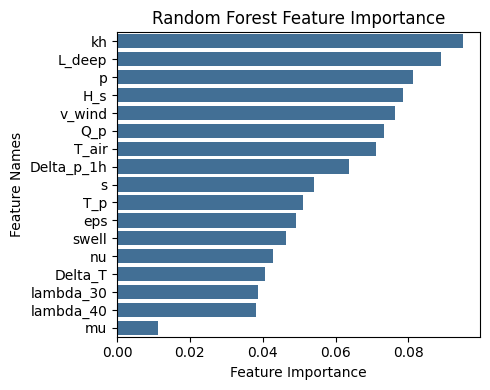

In [5]:
file_plot = f'../results/RFI_{model_type}_model_randomforest_case{case}{"_undersampled" if undersample else ""}.png'
utils.plot_impurity_feature_importance(model.feature_importances_, names=X_train.columns, title="Random Forest Feature Importance", save=file_plot)

### SHAP

In [6]:
# run SHAP
explainer = shap.TreeExplainer(model=model, data=shap.maskers.Independent(X_train, max_samples=100), model_output="probability")
shap_values = explainer(X_train)

# round feature values for better visualization
shap_values.data = X_train.round(4)

100%|===================| 57052/57056 [279:22<00:01]         

In [10]:
#NOTE: the new SHAP package is still a bit buggy.
#      the returned dimensions for the shaply value
#      matrix are swapped. Hence, we need to put
#      then into correct order first.
shap_values.values = list(np.transpose(shap_values.values,(2,0,1)))

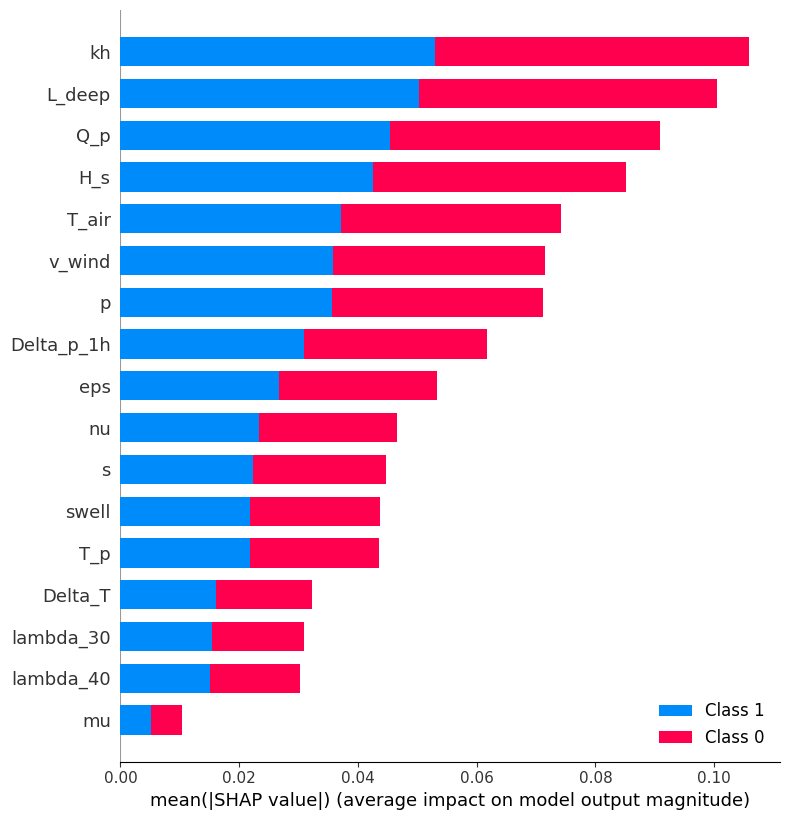

In [11]:
shap.summary_plot(
    shap_values.values, 
    shap_values.data, 
    plot_type='bar')

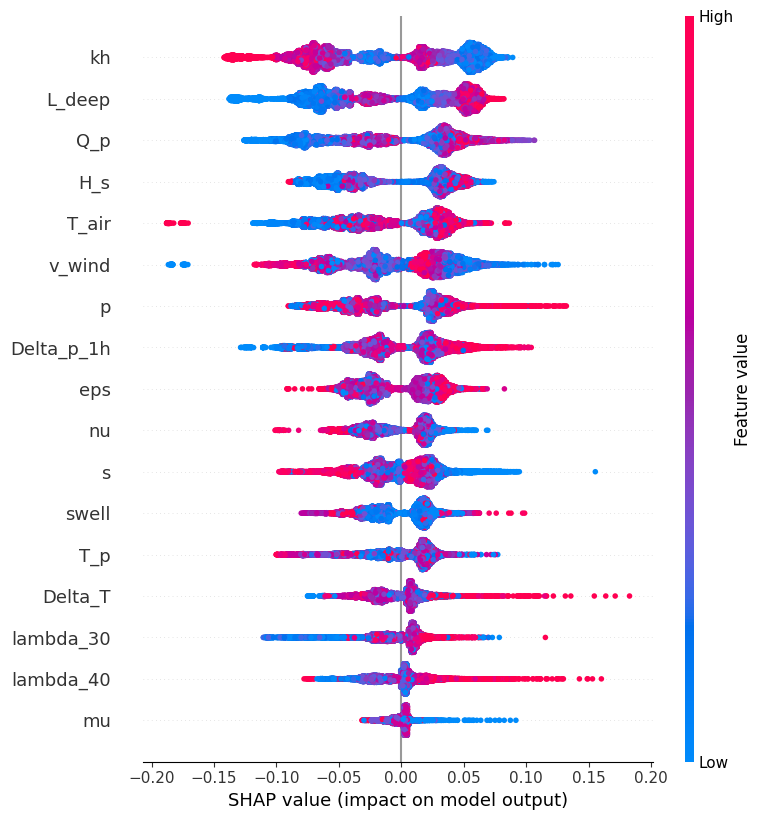

In [12]:
target_class = 0
shap.summary_plot(
    shap_values.values[target_class], 
    shap_values.data)

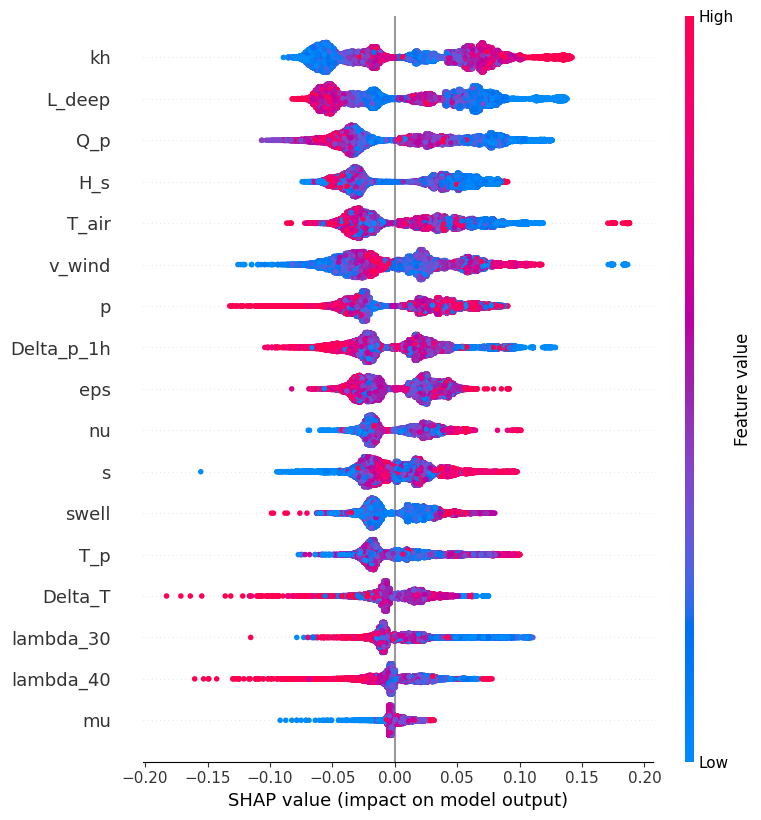

In [13]:
target_class = 1
shap.summary_plot(
    shap_values.values[target_class], 
    shap_values.data)

### Forest-Guided Clustering 

Since the dataset is very large, we run the FGC optimization with subsampling.

In [ ]:
# data_fgc_class = X_train.copy()
# data_fgc_class["target"] = y_train_cat
# data_fgc_class["target"] = data_fgc_class["target"].map({1: 'RogueWave', 0: 'NonRogueWave'})

In [ ]:
# number_of_iterations = 15   # Number of times dataset will be subsampled
# sample_size = 5000           # Number of samples in the subsampled dataset
# max_K = 12                   # Maximum K for the FGC

# k_result_class =  dict((i,0) for i in range(1, max_K)) # Dictionary to store the result

# for i in range(number_of_iterations):
#     print(f"Iteration: {i+1}")
#     # sample the dataset
#     data_sample = data_fgc_class.sample(
#         n = sample_size, replace = False, random_state = i
#         ) # setting random state for reproducibility
#     # instantiate the fgc object on the subsampled dataset and run it:
#     fgc = FgClustering(model=model, data=data_sample, target_column='target')
#     fgc.run(max_K = max_K,
#             method_clustering = 'pam', 
#             discart_value_JI = 0.60, 
#             bootstraps_JI = 100, 
#             n_jobs = n_jobs, 
#             verbose = 1,
#             )
#     # save the result
#     k_result_class[fgc.k] += 1

In [ ]:
# print('Results of k estimation:')
# pd.DataFrame(k_result_class.items(), columns=['k','count']).sort_values(by='count', ascending=False).reset_index(drop=True)

Choose optimal number of clusters k from subsampling optimization and recalculate the clustering for the entire dataset.

In [ ]:
#ks = [...]

#fgc = FgClustering(model=model, data=data_fgc_class, target_column="target")

#for k in ks:
#        fgc.run(k = k, 
#                method_clustering = 'pam', 
#                bootstraps_p_value = 100, 
#                n_jobs = n_jobs, 
#                verbose = 2
#        )

#        filename = f'../results/FGC_k{k}_{model_type}_model_randomforest_case{case}{f"_{undersample_method}_undersampled" if undersample else ""}_test'

#        fgc.plot_feature_importance(save=filename)
#        fgc.plot_decision_paths(save=filename)

## XAI for Regression Model

Next, we repeat the same XAI analysis with the regresison model to see if we get similar results.

### Load Data and Model

In [3]:
undersample = True
undersample_method = "random"
case = 3

model_type = "reg"

Training dataset target distribution:
Counter({0: 14264, 1: 14264, 2: 14264})
Test dataset target distribution:
Counter({1: 122387, 0: 83727, 2: 3566})
Loaded the following model: RandomForestRegressor(criterion='poisson', max_depth=50, max_features='sqrt',
                      max_samples=0.95, n_estimators=1000, oob_score=True,
                      random_state=42)
Train set MSE: 0.001
Train set R^2: 0.99
Train set Spearman R: 0.994


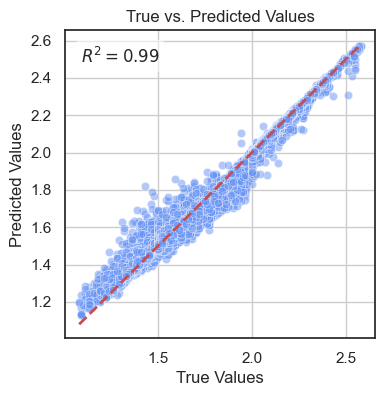

Test set MSE: 0.01
Test set R^2: 0.674
Test set Spearman R: 0.806


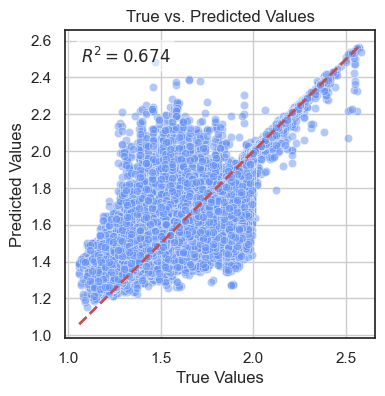

In [4]:
model, X_train, y_train, y_train_cat, X_test, y_test, y_test_cat = utils.load_data_and_model(model_type, case, undersample_method, undersample)

### Random Forest Feature Importance

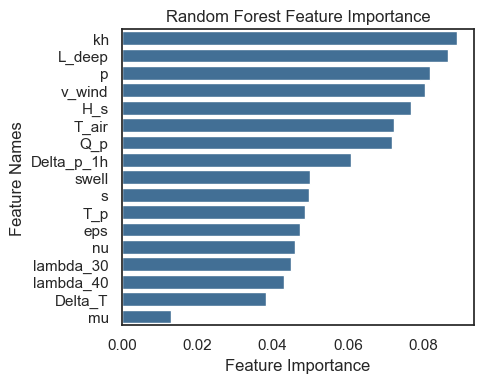

In [5]:
file_plot = f'../results/RFI_{model_type}_model_randomforest_case{case}{"_undersampled" if undersample else ""}.png'
utils.plot_impurity_feature_importance(model.feature_importances_, names=X_train.columns, title="Random Forest Feature Importance", save=file_plot)

### SHAP

In [5]:
# run SHAP
explainer = shap.TreeExplainer(model=model, data=shap.maskers.Independent(X_train, max_samples=100), model_output="raw")
shap_values = explainer(X_train)

# round feature values for better visualization
shap_values.data = X_train.round(4)

: 

In [ ]:
#NOTE: the new SHAP package is still a bit buggy.
#      the returned dimensions for the shaply value
#      matrix are swapped. Hence, we need to put
#      then into correct order first.
shap_values.values = list(np.transpose(shap_values.values,(2,0,1)))

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
shap.plots.beeswarm(shap_values)

### Forest-Guided Clustering

For the regression model we will use the model trained on case 3 with smaples covering the whole output space, but for the XAi analysis with FGC we will use only samples from the case 2 data, where the samples with intermediate values, which are hard to predict, are removed. This should lead to a better clustering due to clearer seperation.

In [ ]:
# _, _, y_train_fgc, _, X_train_fgc, y_test_fgc, _, X_test_fgc = utils.load_data(case=2, undersample=undersample, undersample_method=undersample_method)

# data_fgc_reg = X_train_fgc
# data_fgc_reg["target"] = y_train_fgc

In [ ]:
# number_of_iterations = 15   # Number of times dataset will be subsampled
# sample_size = 5000           # Number of samples in the subsampled dataset
# max_K = 10                   # Maximum K for the FGC

# k_result =  dict((i,0) for i in range(1, max_K)) # Dictionary to store the result

# for i in range(number_of_iterations):
#     print(f"Iteration: {i+1}")
#     # sample the dataset
#     data_sample = data_fgc_reg.sample(
#         n = sample_size, replace = False, random_state = i
#         ) # setting random state for reproducibility
#     # instantiate the fgc object on the subsampled dataset and run it:
#     fgc = FgClustering(model=model, data=data_sample, target_column='target')
#     fgc.run(max_K = max_K,
#             method_clustering = 'pam', 
#             discart_value_JI = 0.60, 
#             bootstraps_JI = 100, 
#             n_jobs = n_jobs, 
#             verbose = 1,
#             )
#     # save the result
#     k_result[fgc.k] += 1

In [ ]:
# print('Results of k estimation:')
# pd.DataFrame(k_result.items(), columns=['k','count']).sort_values(by='count', ascending=False).reset_index(drop=True)

In [ ]:
# ks = [...]

# fgc = FgClustering(model=model, data=data_fgc_reg, target_column="target")

# for k in ks:
#         fgc.run(k = k, 
#                 method_clustering = 'pam', 
#                 bootstraps_p_value = 100, 
#                 n_jobs = n_jobs, 
#                 verbose = 2
#         )

#         filename = f'../results/FGC_k{k}_{model_type}_model_randomforest_case{case}{f"_{undersample_method}_undersampled" if undersample else ""}_test'

#         fgc.plot_feature_importance(save=filename)
#         fgc.plot_decision_paths(save=filename)